In [2]:
import sys
sys.path.append("..")

import pickle
import multiprocessing as mp
from dynetworkx import dynetworkx as dnx
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [3]:
# gets the graph dataset

with open('data/graphs.pickle','rb') as f:
    graphs = pickle.load(f)

# This list all of the edge orders for the motifs in the table above
motifs = [[((1,2),(3,2),(1,2)), ((1,2),(3,2),(2,1)), ((1,2),(3,2),(1,3)), ((1,2),(3,2),(3,1)), ((1,2),(3,2),(2,3)), ((1,2),(3,2),(3,2))],
          [((1,2),(2,3),(1,2)), ((1,2),(2,3),(2,1)), ((1,2),(2,3),(1,3)), ((1,2),(2,3),(3,1)), ((1,2),(2,3),(2,3)), ((1,2),(2,3),(3,2))],
          [((1,2),(3,1),(1,2)), ((1,2),(3,1),(2,1)), ((1,2),(3,1),(1,3)), ((1,2),(3,1),(3,1)), ((1,2),(3,1),(2,3)), ((1,2),(3,1),(3,2))],
          [((1,2),(1,3),(1,2)), ((1,2),(1,3),(2,1)), ((1,2),(1,3),(1,3)), ((1,2),(1,3),(3,1)), ((1,2),(1,3),(2,3)), ((1,2),(1,3),(3,2))],
          [((1,2),(2,1),(1,2)), ((1,2),(2,1),(2,1)), ((1,2),(2,1),(1,3)), ((1,2),(2,1),(3,1)), ((1,2),(2,1),(2,3)), ((1,2),(2,1),(3,2))],
          [((1,2),(1,2),(1,2)), ((1,2),(1,2),(2,1)), ((1,2),(1,2),(1,3)), ((1,2),(1,2),(3,1)), ((1,2),(1,2),(2,3)), ((1,2),(1,2),(3,2))]]

mot = [ seq for row in motifs for seq in row]

In [4]:
# gets the nodes that are strongly connected, and graphs them

graph_0_networkx = graphs[0].to_networkx_graph()
graph_0_strong_conn= nx.strongly_connected_components(graph_0_networkx)

def get_strongly_connected(graph):
    for i in graph:
        yield i

len_longest = 0
longest = 0
for i in get_strongly_connected(graph_0_strong_conn):
    if len(i) > len_longest:
        longest = i
        len_longest = len(longest)
print(longest)
print(len_longest)

graph_0_strong_conn = graph_0_networkx.subgraph(longest)

{'EGY', 'POL', 'KEN', 'DJI', 'CAM', 'CHA', 'CRO', 'HAI', 'TAZ', 'COS', 'YEM', 'SYR', 'BUL', 'DRC', 'BEL', 'MAL', 'EST', 'LBR', 'NOR', 'GRG', 'KYR', 'UZB', 'ANG', 'IND', 'UGA', 'DRV', 'LIT', 'POR', 'AFG', 'BNG', 'SUR', 'CYP', 'NTH', 'ITA', 'DEN', 'PER', 'BUI', 'LUX', 'IRQ', 'CZR', 'RUM', 'TAW', 'FIN', 'SPN', 'MOR', 'IRN', 'NEP', 'ARM', 'YUG', 'CAN', 'AUL', 'LEB', 'RWA', 'ISR', 'PAK', 'LIB', 'ALB', 'UKG', 'SUD', 'SLV', 'TAJ', 'BOS', 'USA', 'COL', 'FRN', 'MAC', 'TUR', 'PRK', 'MYA', 'GUI', 'UAE', 'GMY', 'HUN', 'SIE', 'AZE', 'TUN', 'SOM', 'ZIM', 'SLO', 'PAN', 'KUW', 'THI', 'GRC', 'SWD', 'CHN', 'GUY', 'SSD', 'SAU', 'JPN', 'HON', 'ZAM', 'LAT', 'ROK', 'VTM', 'RUS', 'ETH', 'ICE', 'MLD', 'JOR', 'ECU', 'ERI', 'CDI', 'ARG', 'INS', 'NIC', 'VEN', 'PHI', 'UKR'}
108


In [5]:
# edits the 0th graph in graphs to remove the non-strongly connected nodes

for edge in graphs[0].edges():
    if edge[0] not in longest or edge[1] not in longest:
        graphs[0].remove_edge(edge[0], edge[1])

In [6]:
# stores all of the (pandas dataframes that tells you how many times each node appears in each motif) for each of the (10 graphs) in count_table

table = list()

for g in graphs:
    
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap_async(dnx.count_temporal_motif, [(g, seq, 7*86400) for seq in mot]).get()
    pool.close()
    
    count = list()
    for d in results:
        #count.append(d) # if using older version of dynetworkx
        count.append(d[2])
    table.append(count)

    break # we only use the first graph
    

count_table = pd.DataFrame(table, columns=mot)

In [7]:
df = count_table # saves count_table as df so we can manipulate count_table but also retain the original copy

# count_table_multiindex is a list that stores each multiindex dataframe for each of the 10 datasets
count_table_multiindex = []

for current_dataset in range(len(df.index)):

    # there are three (or two) positions in each motif
    positions = [1, 2, 3]

    # generates list of all countries by compiling all countries in all 10 datasets in all 36 motifs
    countries = []
    for i in range(len(df.index)):
        for k in range(len(df.columns)):
            countries += list(df.iloc[i][k].index)
    countries = sorted(list(set(countries)))

    # generates the index for the multiindex by taking the product of mot and positions
    multiindex_vals = pd.MultiIndex.from_product([mot, positions], names=["motifs", "positions"])

    # creates the dataframe with indices from multiindex_vals and columns from countries
    dataset_df = pd.DataFrame(columns=countries, index=multiindex_vals)

    # iterates through all positions in the multiindex dataframe (through all motifs, position in each motif, and each country) and assigns the appropriate value based on df
    for motif in mot:
        for pos in positions:
            for country in countries:

                # checks if country and position is present in df and then assigns it
                if country in df.loc[current_dataset][motif].index and pos in df.loc[current_dataset][motif].columns:
                    dataset_df[country].loc[(motif, pos)] = df.loc[current_dataset][motif].loc[country][pos]

    # adds the dataframe to the list
    count_table_multiindex.append(dataset_df)

/var/folders/wr/1ygr91094fx7s8n65by5s4c40000gn/T/ipykernel_33966/3840050657.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  countries += list(df.iloc[i][k].index)
/var/folders/wr/1ygr91094fx7s8n65by5s4c40000gn/T/ipykernel_33966/3840050657.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` i

In [8]:
# changes all 'nan' to 0, normalizes vectors, deletes countries with too few edges

count_table0 = count_table_multiindex[0].copy()

count_table0 = count_table0.fillna(0)

countries = list(count_table0.columns)

# removes positional information from count_table0
count_table0_positionless = pd.DataFrame(0, columns=countries, index=mot)
for motif in mot:
    for position in positions:
       for country in countries:
            count_table0_positionless[country][motif] += count_table0[country][(motif, position)]
count_table0 = count_table0_positionless

# remove countries with less than some number of edges; normalization
for column in count_table0.columns:
    sum = count_table0[column].sum()
    if sum > 10:
        count_table0[column] = count_table0[column].apply(lambda x: x / sum) # normalize
    else:
        count_table0 = count_table0.drop(column, axis=1)

# gets updated list of countries in dataframe
countries = list(count_table0.columns)

/var/folders/wr/1ygr91094fx7s8n65by5s4c40000gn/T/ipykernel_33966/1343173517.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  count_table0 = count_table0.fillna(0)
/var/folders/wr/1ygr91094fx7s8n65by5s4c40000gn/T/ipykernel_33966/1343173517.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[r

In [9]:
# list of countries
list_of_countries = list(count_table0.columns)

# conversion from country number to country name
dict_of_countries = {}
for i in range(len(list_of_countries)):
    dict_of_countries[i] = list_of_countries[i]

list_of_motif_pos = list(multiindex_vals)

print(dict_of_countries)
print(list_of_countries)
print(list_of_motif_pos)

{0: 'AFG', 1: 'ALB', 2: 'ARG', 3: 'ARM', 4: 'AUL', 5: 'AZE', 6: 'BEL', 7: 'BNG', 8: 'BOS', 9: 'BUL', 10: 'CAM', 11: 'CAN', 12: 'CHN', 13: 'CRO', 14: 'CYP', 15: 'CZR', 16: 'DEN', 17: 'DRC', 18: 'DRV', 19: 'ECU', 20: 'ERI', 21: 'EST', 22: 'FIN', 23: 'FRN', 24: 'GMY', 25: 'GRC', 26: 'GRG', 27: 'HAI', 28: 'HUN', 29: 'ICE', 30: 'IND', 31: 'IRN', 32: 'IRQ', 33: 'ISR', 34: 'ITA', 35: 'JOR', 36: 'JPN', 37: 'KUW', 38: 'KYR', 39: 'LEB', 40: 'LIB', 41: 'LIT', 42: 'LUX', 43: 'MAC', 44: 'MOR', 45: 'MYA', 46: 'NOR', 47: 'NTH', 48: 'PAK', 49: 'PER', 50: 'PHI', 51: 'POL', 52: 'POR', 53: 'PRK', 54: 'ROK', 55: 'RUS', 56: 'RWA', 57: 'SAU', 58: 'SLO', 59: 'SLV', 60: 'SPN', 61: 'SUD', 62: 'SWD', 63: 'SYR', 64: 'TAJ', 65: 'TAW', 66: 'THI', 67: 'TUR', 68: 'UAE', 69: 'UGA', 70: 'UKG', 71: 'UKR', 72: 'USA', 73: 'UZB', 74: 'YEM', 75: 'YUG'}
['AFG', 'ALB', 'ARG', 'ARM', 'AUL', 'AZE', 'BEL', 'BNG', 'BOS', 'BUL', 'CAM', 'CAN', 'CHN', 'CRO', 'CYP', 'CZR', 'DEN', 'DRC', 'DRV', 'ECU', 'ERI', 'EST', 'FIN', 'FRN', 'GMY

In [10]:
# appends a heatmap to fig
# spacing optimized for 7 heatmaps

def insert_heatmap(fig, data, max_val, row, col):
    fig.append_trace(go.Heatmap(
                     z=data,
                     x=[1,2,3,4,5,6],
                     y=[6,5,4,3,2,1],
                     #colorscale='greens',
                     #colorbar=dict(x=0.21),
                     zmax=1,
                     zmid=0.5,
                     zmin=0,
                     #coloraxis='coloraxis',
                     colorscale = [[0, 'rgb(256,256,256)'], [0.25, 'rgb(198,233,191)'], [0.5, 'rgb(116,196,118)'], [0.75, 'rgb(32,137,68)'], [1, 'rgb(0,68,27)']],
                  ),
                  row, col)
    
def create_centroid_heatmaps(centroids):
    num_clusters = len(centroids)

    all_the_data = [] # stores all of the data for the heatmaps: list of n centroids, each centroid is a 6x6 list

    for centroid in range(num_clusters):

        # adjusts the data so it fits into the 6x6 heatmaps
        data = []
        for i in range(6):
            i = 5-i
            data.append(centroids[centroid][i*6:i*6+6])
        all_the_data.append(data)
            
    # makes the subplot titles
    subplot_titles = []
    for i in range(num_clusters):
        subplot_titles.append('Centroid ' + str(i))
        subplot_titles.append('')
        subplot_titles.append('')

    # makes the fig
    fig = make_subplots(rows=num_clusters, cols=3, subplot_titles=subplot_titles, vertical_spacing=0.025)

    # inserts heatmaps into fig
    for k in range(len(all_the_data)):

        # calculates the maximum value of all the data
        max_val = 0
        for i in range(len(all_the_data[k])):
            max_val = max([max_val] + all_the_data[k][i])

        # inserts heatmaps
        insert_heatmap(fig, all_the_data[k], max_val, k+1, 1)

    fig.update_layout(title=f'Centroid Data - {num_clusters} Clusters',
                    height=365*num_clusters,
                    width=1200,
                    #coloraxis = {'colorscale':'greens'}
                    )
    fig.update_yaxes(autorange="reversed")
    fig.update_xaxes(tickvals = [1,2,3,4,5,6])
    
    return fig

In [11]:
# dictionary that converts the COW country code into the long name
cow_country_codes = pd.read_csv("data/COW-country-codes.csv")
cow_country_codes = cow_country_codes.set_index('COWcode')['name'].T.to_dict()

list_of_countries_spelled = []

for i in range(len(list(count_table0.columns))):
    country = count_table0.columns[i]
    list_of_countries_spelled.append(cow_country_codes[country])

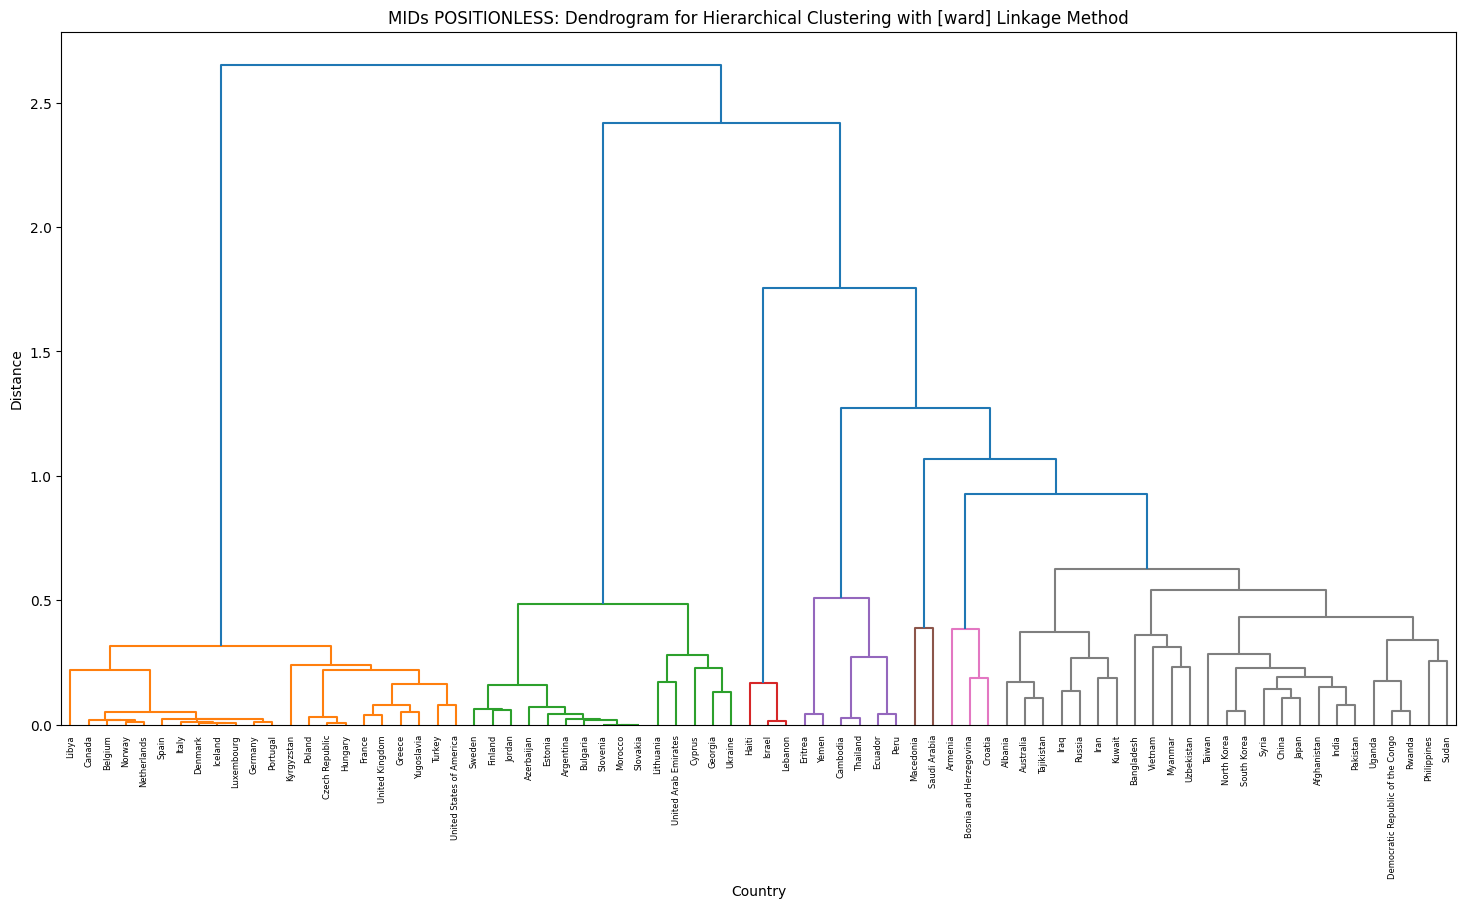

In [12]:
# hierarchical clustering
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
# https://stackoverflow.com/questions/9838861/scipy-linkage-format
# https://python-graph-gallery.com/401-customised-dendrogram/

method = 'ward'
Z = linkage(count_table0.T, method=method)

plt.figure(figsize=(18, 9))
dendrogram(Z, labels=list_of_countries_spelled, color_threshold=0.75)#, labels=list(count_table[0].columns))
plt.title(f'MIDs POSITIONLESS: Dendrogram for Hierarchical Clustering with [{method}] Linkage Method')
plt.xlabel('Country')
plt.ylabel('Distance')
plt.show()

In [13]:
# split into 7 clusters

dendrogram_clustering = fcluster(Z, t=7, criterion='maxclust')
print(dendrogram_clustering)

memberships = [[] for _ in range(7)]
for i in range(len(list_of_countries)):
    memberships[int(dendrogram_clustering[i])-1].append(list_of_countries[i])

for i in range(len(memberships)):
    print(f'Cluster {i}: {memberships[i]}')

[7 7 2 6 7 2 1 7 6 2 4 1 7 6 2 1 1 7 7 4 4 2 2 1 1 1 2 3 1 1 7 7 7 3 1 2 7
 7 1 3 1 2 1 5 2 7 1 1 7 4 7 1 1 7 7 7 7 5 2 2 1 7 2 7 7 7 4 1 2 7 1 2 1 7
 4 1]
Cluster 0: ['BEL', 'CAN', 'CZR', 'DEN', 'FRN', 'GMY', 'GRC', 'HUN', 'ICE', 'ITA', 'KYR', 'LIB', 'LUX', 'NOR', 'NTH', 'POL', 'POR', 'SPN', 'TUR', 'UKG', 'USA', 'YUG']
Cluster 1: ['ARG', 'AZE', 'BUL', 'CYP', 'EST', 'FIN', 'GRG', 'JOR', 'LIT', 'MOR', 'SLO', 'SLV', 'SWD', 'UAE', 'UKR']
Cluster 2: ['HAI', 'ISR', 'LEB']
Cluster 3: ['CAM', 'ECU', 'ERI', 'PER', 'THI', 'YEM']
Cluster 4: ['MAC', 'SAU']
Cluster 5: ['ARM', 'BOS', 'CRO']
Cluster 6: ['AFG', 'ALB', 'AUL', 'BNG', 'CHN', 'DRC', 'DRV', 'IND', 'IRN', 'IRQ', 'JPN', 'KUW', 'MYA', 'PAK', 'PHI', 'PRK', 'ROK', 'RUS', 'RWA', 'SUD', 'SYR', 'TAJ', 'TAW', 'UGA', 'UZB']


In [14]:
# heatmaps for hierarchcal clustering

hierarchical_centroids = []
for group in memberships:
    hierarchical_centroids.append(list(count_table0[group].mean(axis=1)))

# creates the heatmaps for the hierarchical clustering

fig = create_centroid_heatmaps(hierarchical_centroids)
fig.update_layout(title=f'MIDs POSITIONLESS: Hierarchical Clustering - {len(memberships)} Clusters')
fig.show()